In [1]:
#Import of all the necessary libraries
import pyshtools as pysh
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import pygmt
from palettable import scientific as scm
import numpy as np
import h5py
import matplotlib.gridspec as gridspec


C:\Users\Annze\anaconda3\envs\spyder\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#Import the dataset that was created by Tsunakawa et al. 2015 - Spherical harmonic expansion of the global magnetic field
pysh.utils.figstyle(rel_width=0.75) 
clm = pysh.datasets.Moon.T2015_449()
clm.info() 
#creation of the grid and initialization of parameters
grid = clm.expand() #creating the grid
Nlat = grid.nlat #latitude
Nlon = grid.nlon #longitude
#initialization of the magnetic field
Nz=100
Bx=np.zeros((Nlat,Nlon,Nz))
By=np.zeros((Nlat,Nlon,Nz))
Bz=np.zeros((Nlat,Nlon,Nz))


kind = 'real'
normalization = 'schmidt'
csphase = 1
lmax = 449
r0 (m) = 1737400.0
error_kind = None
header = ['1737.4e3', '449']
header2 = None
name = 'T2015_449'
units = 'nT'
year = None


In [3]:
r0= clm.r0 #mean radius of the Moon
r= clm.r0+30000 #Here we choose the altitude at which the data were selected by the spacecraft
for iz in range(0,Nz):
    grid = clm.expand(a=r+iz*1e5) #here we choose the grid step
    xgrid=grid.to_xarray()  #generates array
    #Here we create the matrices for the magnetic field components
    Bz[:,:,iz] = xgrid.radial.values
    By[:,:,iz] = xgrid.theta.values 
    Bx[:,:,iz] = xgrid.phi.values 

In [4]:
#We check the dimensions of the vectors
print(Nlat,Nlon,Bx.shape)
np.shape(Bx)

901 1801 (901, 1801, 100)


(901, 1801, 100)

In [5]:
#We check the grid - Longitude and Latitde grids
print(xgrid)
print(xgrid.lat.values*np.pi/180)
print(xgrid.lon.values*np.pi/180)


<xarray.Dataset>
Dimensions:    (lat: 901, lon: 1801)
Coordinates:
  * lat        (lat) float64 90.0 89.8 89.6 89.4 ... -89.4 -89.6 -89.8 -90.0
  * lon        (lon) float64 0.0 0.2 0.4 0.6 0.8 ... 359.4 359.6 359.8 360.0
Data variables:
    radial     (lat, lon) float64 -6.559e-06 -6.559e-06 ... 1.866e-05 1.866e-05
    theta      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    phi        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    total      (lat, lon) float64 6.559e-06 6.559e-06 ... 1.866e-05 1.866e-05
    potential  (lat, lon) float64 -48.83 -48.83 -48.83 ... 96.22 96.22 96.22
Attributes: (12/13)
    title:        
    description:  
    comment:      pyshtools grid
    nlat:         901
    nlon:         1801
    lmax:         449
    ...           ...
    a:            11667400.0
    f:            0.0
    lmax_calc:    449
    sampling:     2
    n:            900
    extend:       True
[ 1.57079633  1.56730567  1.56381501  1.56032435  1.55

In [6]:
#We consider the real descritization in both spherical and cartesian coordinates
r=r0/1000 #r0 is the radius of the Moon in meters
dr = 0.2*np.pi/180 #Tsunakawa considered equidistant points of distance equal to 0.2 degrees
dphi = 0.2*np.pi/180 
dtheta = 0.2*np.pi/180
#Now we calculate the grid size in Cartesian coordinates
dx = r*dphi
dy = r*dtheta
dz = r*dphi

In [7]:
#Here we create an h5 file that contains the lunar magnetic field in cartesian coordinates
filename = "Magnetic_field_30km_altitude"
file = h5py.File(filename,'w')
file.create_dataset('Bx',(Nz,Nlat,Nlon),data=Bx)
file.create_dataset('By',(Nz,Nlat,Nlon),data=By)
file.create_dataset('Bz',(Nz,Nlat,Nlon),data=Bz)
file.close()

In [9]:
 def write_vtk_bin_vector(fn,Bx, By, Bz,dx,dy,dz,flag):
    fid = open(fn, 'w')
    fid.write('# vtk DataFile Version 2.0\n')  # vtk DataFile Version x.x
    fid.write('Generated by python\n')  # comments
    fid.write('BINARY\n')  # ASCII
    fid.write('DATASET STRUCTURED_POINTS\n')
    Nz=Bx.shape[2]
    Ny=Bx.shape[1]
    Nx=Bx.shape[0]
    fid.write('DIMENSIONS\t'+str(Nz)+'\t'+str(Ny)+'\t'+str(Nx)+'\n')
    fid.write('ORIGIN  0  0  0\n')
    fid.write('SPACING\t'+str(dz)+'\t'+str(dy)+'\t'+str(dx)+'\n')
    fid.write('POINT_DATA\t'+str(Nx*Ny*Nz)+'\n')
    fid.write('VECTORS '+flag+' float\n')
    fid.close()
    fid = open(fn, 'a+b')
    B=np.zeros((Nx,Ny,Nz,4))
    B[:,:,:,0]=Bz[:,:,:]
    B[:,:,:,1]=By[:,:,:]
    B[:,:,:,2]=Bx[:,:,:]
    #For the regional analysis of the lunar magnetic field we limit our study here to specific regions by changing the indices
    #in these vectors
    #V[:,:,:,0]=Vz[499:502,1100:1103,0:3]
    #V[:,:,:,1]=Vy[499:502,1100:1103,0:3]
    #V[:,:,:,2]=Vx[499:502,1100:1103,0:3]
    # Attention, Paraview expects file in big endian binary.
    B.astype(np.float32).byteswap().tofile(fid)
    fid.close()
    return True

In [10]:
#Here we create the vtk file to visualize it by using Paraview
#dx, dy, dz must be set to their physical values
write_vtk_bin_vector('Magnetic_field_30km_altitude',Bx, By, Bz,dx,dy,dz,'B')

True

In [11]:
B = np.sqrt(Bx**2+By**2+Bz**2)

In [12]:
Blog = np.log(B)

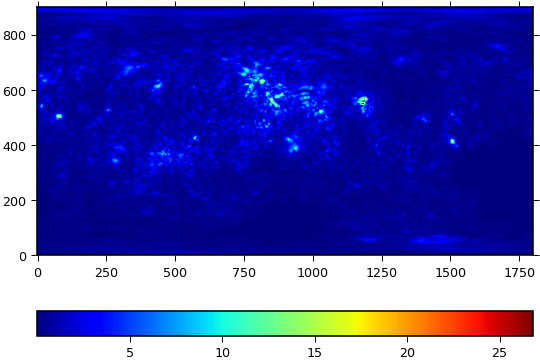

In [13]:
#Here we create the global map of the total magnetic field
import matplotlib.cm as cm
import matplotlib.colors as colors
CF=plt.imshow(B[:,:,0], cmap=cm.jet, 
	   interpolation='nearest', origin='lower')
CBI = plt.colorbar(CF, orientation='horizontal')


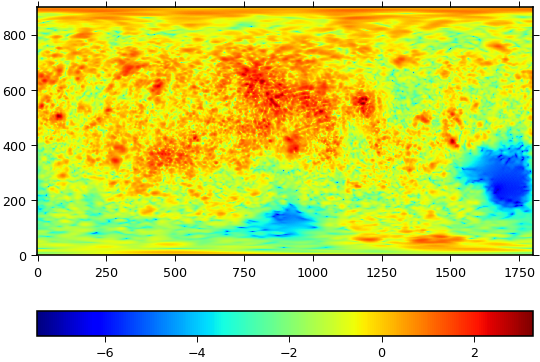

In [14]:
#Here we create the global map in a logarithmic scale
CF=plt.imshow(Blog[:,:,0], cmap=cm.jet, 
	   interpolation='nearest', origin='lower')
CBI = plt.colorbar(CF, orientation='horizontal')